# Generating Cost Maps from GeoTIFF Images

The following example will provide users with a tutorial on the capabilities of the Mapstery package for generating cost maps from images.

## Import

In [1]:
import numpy as np
import mapstery
from mapstery.filter import move_dynamics
from IPython.core.display import Image, display
import PIL

## Loading Spatial Information

In [2]:

M = mapstery.Map("/data/moonlab/slope-1-shadow-2-169.gtif")
# --- This is similar to:
# M = mapstery.Map()
# M.dataset = "/data/moonlab/slope-1-shadow-2-169.gtif"


Slope has been extracted for demo


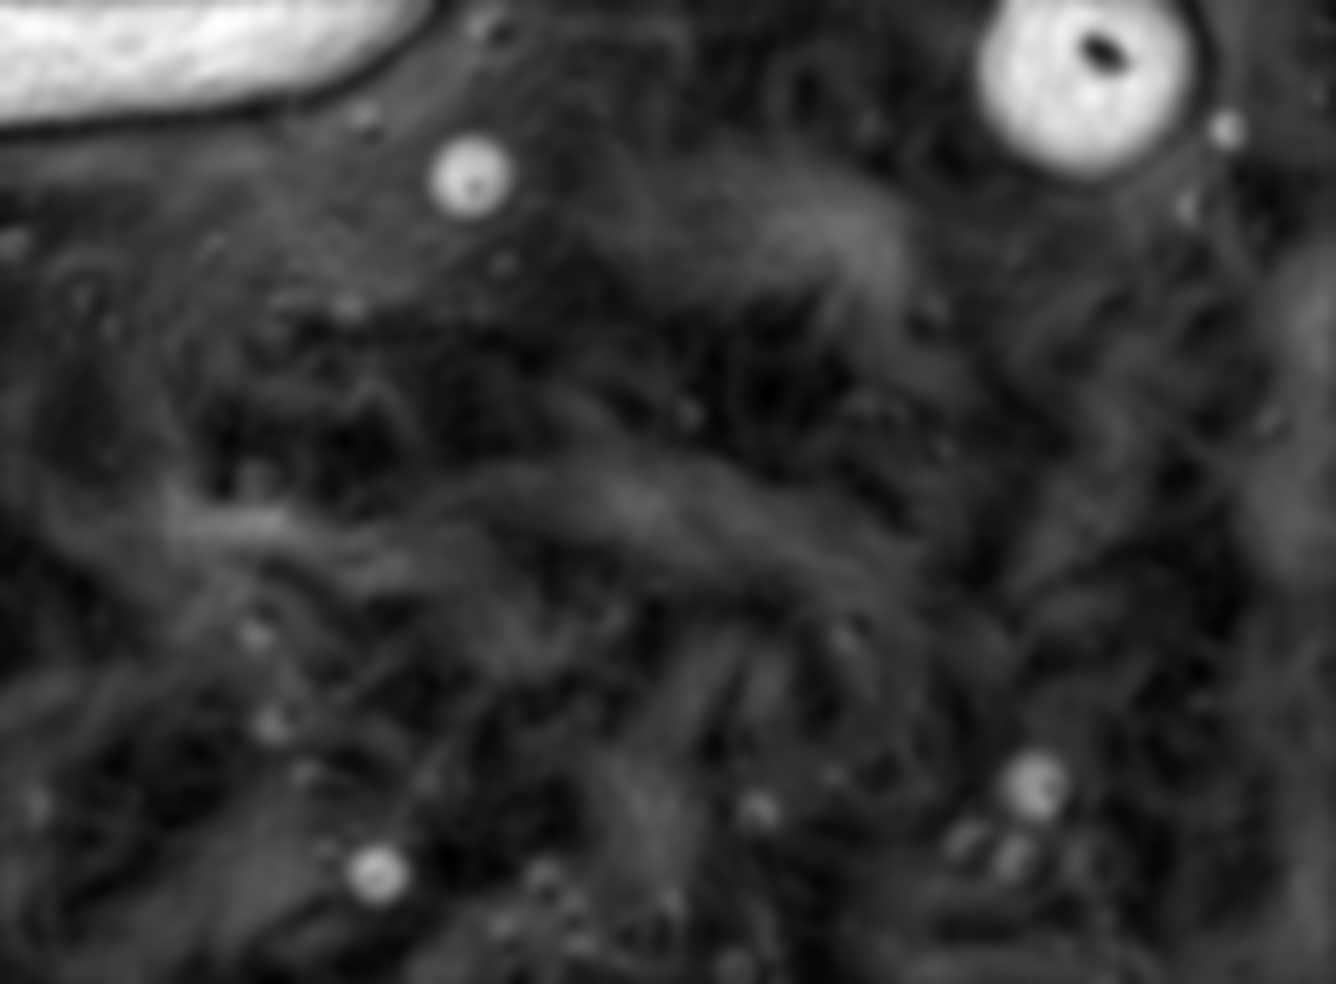

In [3]:
if M.save_band(1, "/tmp/slope.png"):
    print("Slope has been extracted for demo")

display(Image("/tmp/slope.png", width=500, unconfined=False))

Shadow 1 has been extracted for demo


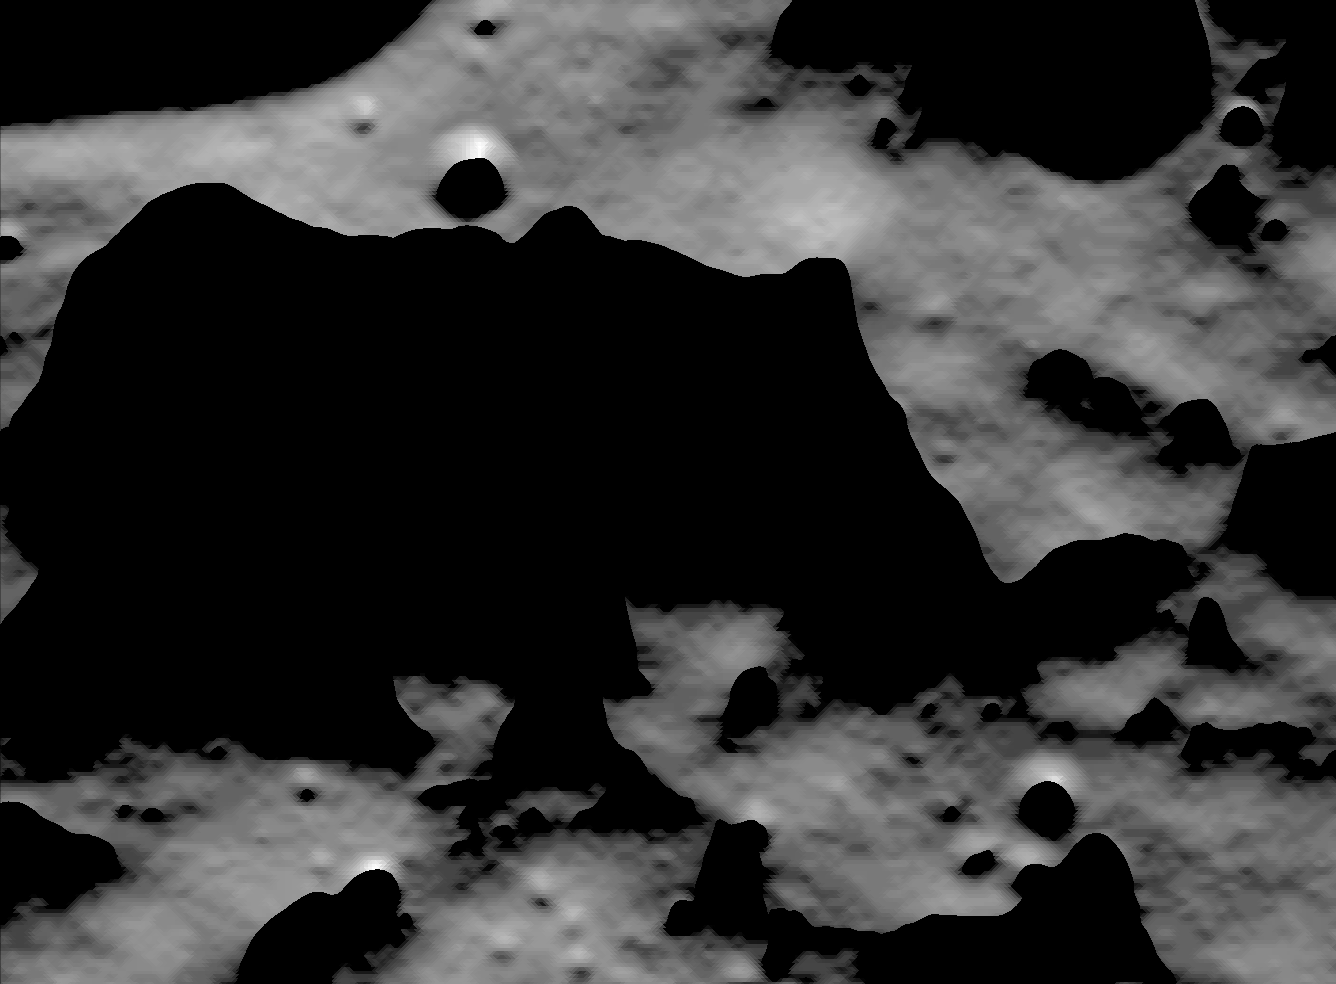

In [4]:
if M.save_band(2, "/tmp/shadow.png"):
    print("Shadow 1 has been extracted for demo")

display(Image("/tmp/shadow.png", width=500, unconfined=False))

## Creating a simple cost map

### Getting the data of two bands slope + shadow

In [5]:
# Get the slope information using band  by name as numpy array
slope_contribution = M.get_band_by_name("SLOPE").ReadAsArray()
slope_contribution = slope_contribution.astype(np.float)
print("Min {}, Max {}".format(np.min(slope_contribution), np.max(slope_contribution)))

Min 0.0, Max 255.0


In [6]:
# Get the corresponding shadow information (direct or integrated shadow) as numpy array
shadow_contribution = M.get_band(2).ReadAsArray()
shadow_contribution = shadow_contribution.astype(np.float)
print("Min {}, Max {}".format(np.min(shadow_contribution), np.max(shadow_contribution)))

Min 0.0, Max 221.0


### These two information are antonyms.
We need to invert one or the other as dark slope means high traversability and dark shadow is the total contrary.
Let's consider __light areas__ where you don't want the robot to go. Mathematically this prevent us from using the invert function.

In [7]:
# shadow_contribution is all set
shadow_contribution = move_dynamics(shadow_contribution, target_max_bound=1.0)
shadow_contribution = 1.0 - shadow_contribution

In [8]:
# slope has to be inverted. Dark areas are flat areas so we love them.
slope_contribution = move_dynamics(slope_contribution, target_max_bound=1.0)

### Simple addition of different bands using the robot's model

In [9]:
# Robot's very simple model 
ROBOT_ON_SLOPE = 10.0
ROBOT_IN_SHADOW = 8.0

# Evaluating cost 0 to 1 and then converting to image between 0 and 255
cost_map = ROBOT_ON_SLOPE * slope_contribution + ROBOT_IN_SHADOW * shadow_contribution
cost_map = move_dynamics(cost_map) # picture ready with greyscale between 0 and 255

In [10]:
P = PIL.Image.fromarray(cost_map.astype(np.uint8))
P.save("/tmp/cost_map_1.png")

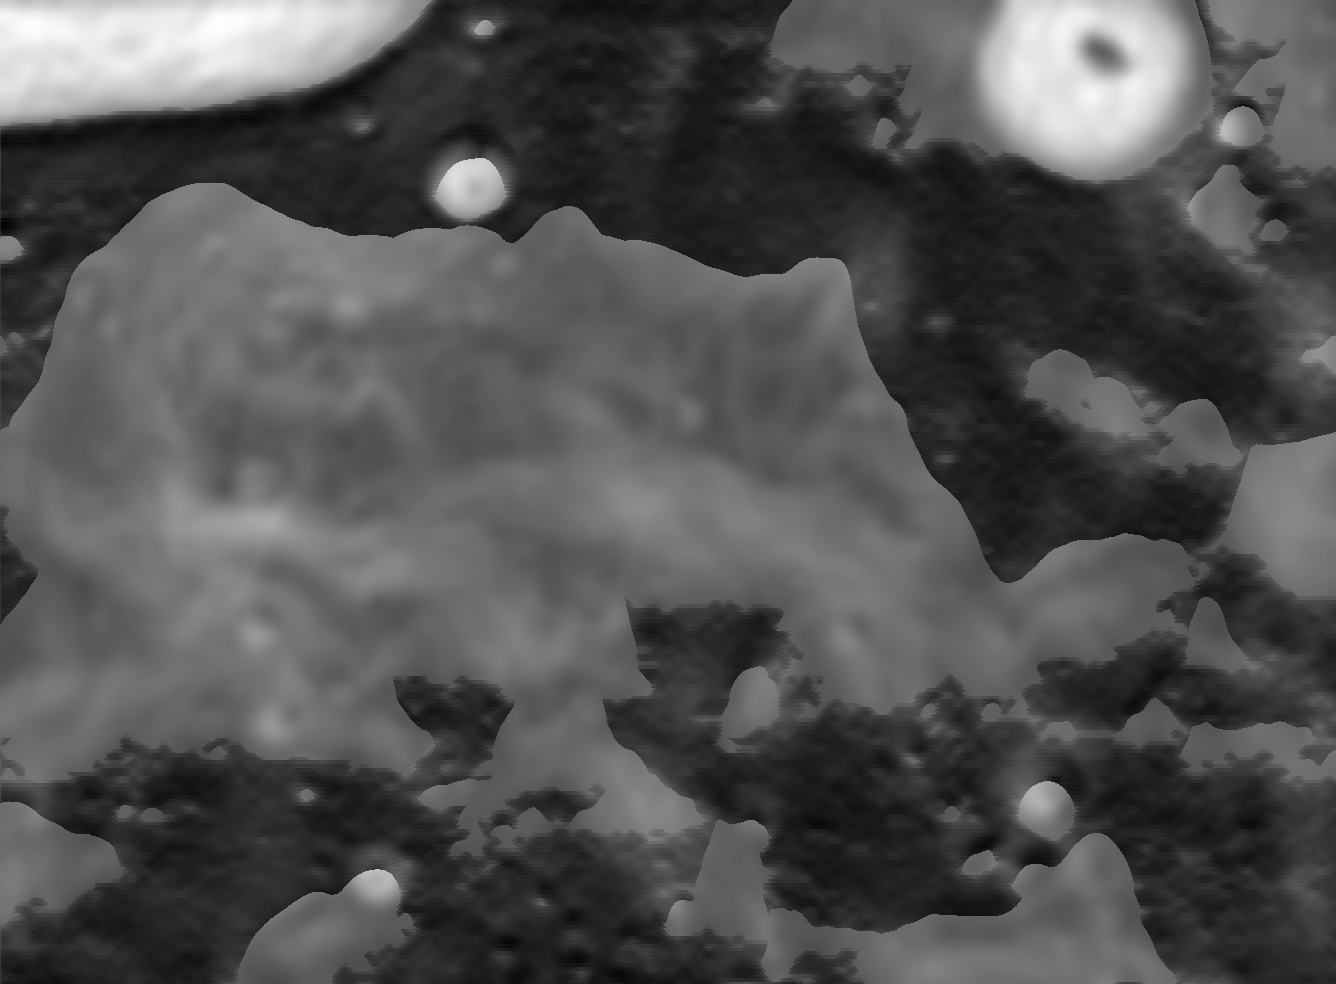

In [11]:
display(Image("/tmp/cost_map_1.png", width=500, unconfined=False))

### Testing a multiplication
By default mapstery bands are in float precision

In [12]:
cost_map_2 = slope_contribution * shadow_contribution
cost_map_2 = mapstery.filter.move_dynamics(cost_map_2)

In [13]:
P = PIL.Image.fromarray(cost_map_2.astype(np.uint8))
P.save("/tmp/cost_map_2.png")

Cost map has been exported for display


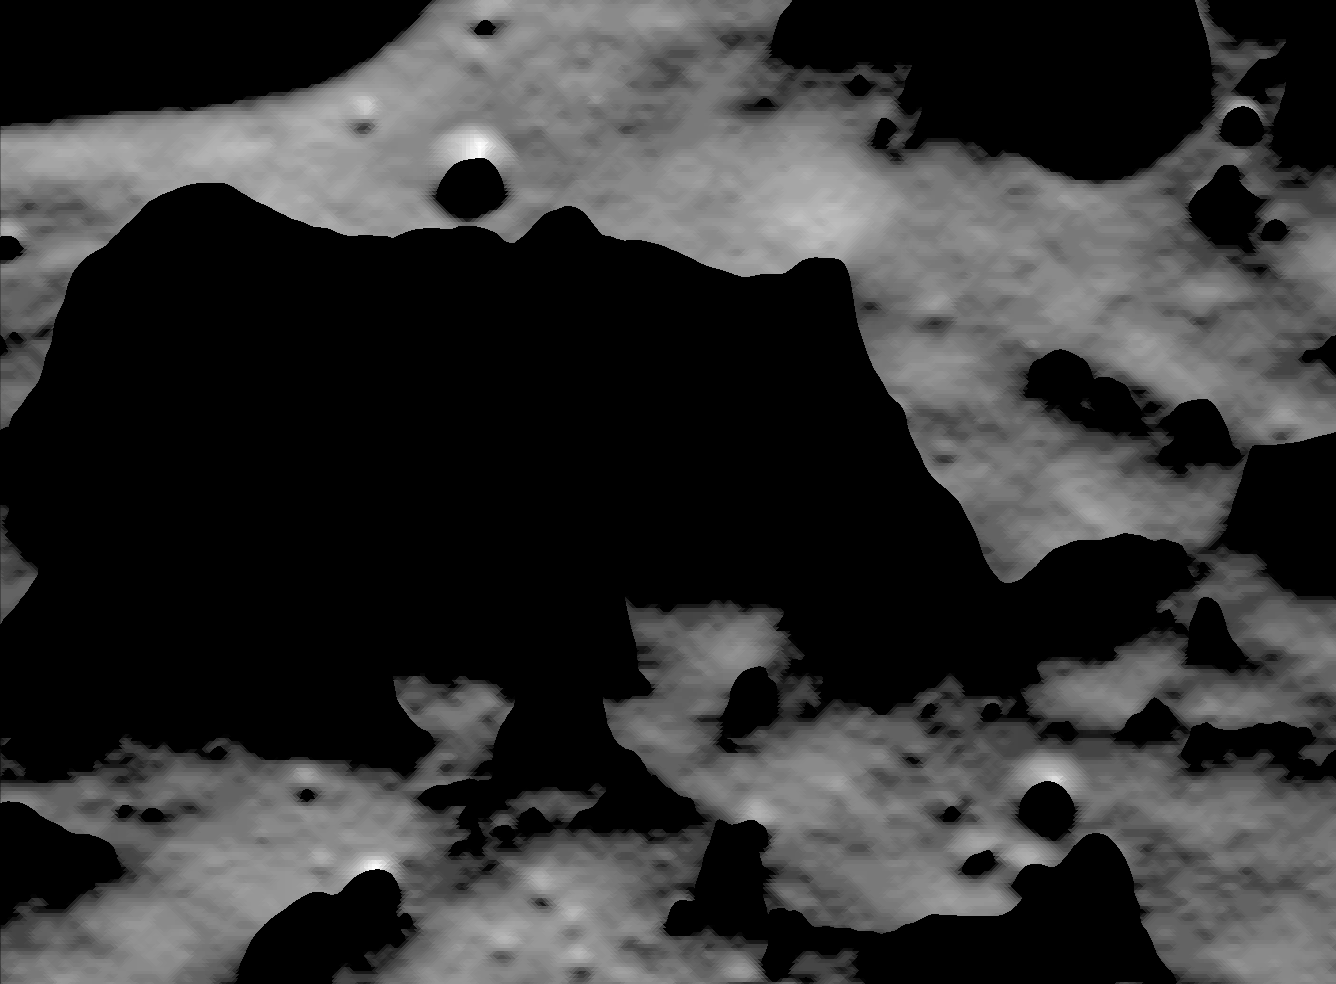

In [14]:
M.save_band(169, "/tmp/cost_map2.png")
print("Cost map has been exported for display")

display(Image("/tmp/cost_map2.png", width=500, unconfined=False))

*Nota Bene: new bands are overwriting the last one 169. To be fixed on mapstery. But once you have your costmap you do not need to go through mapstery again at the moment you can just use the numpy array as is.*